# Build a NER model with variants of RNN - 
* A single-layer RNN network.
* A k-layer RNN network, where k=[2,3]. 
* A bidirectional single-layer RNN. 
* A bidirectional k-layer RNN, where k=[2,3].

With hidden layers in the range - [8, 32, 64]

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense

Read CSV file

In [ ]:
df = pd.read_csv('./ner_dataset.csv', encoding= 'unicode_escape', usecols=['Sentence #','Word','Tag'])

The dataset contains all the sentences, with each word tagged. </br>
The tags can be:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

Extract each sentence and transform it into an adequate format.  You can use **df.fillna(method='ffill', inplace=True)** to fill the NaN values and extract the values easily.</br>


In [ ]:
df.fillna(method='ffill', inplace=True)
df['Sentence #'] = df['Sentence #'].str.replace('Sentence: ','').astype(int)
df.set_index('Sentence #', inplace=True)
df.head()

,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


In [ ]:
index, length = np.unique(df.index, return_counts=True)

b1 = length>15
b2 = length<30
b = np.logical_and(b1, b2)

index = index[b]
length = length[b]

df = df.loc[index]

In [ ]:
index = np.unique(df.index)

train_index, val_index = train_test_split(index, train_size=0.8)

df_train = df.loc[train_index]
df_val = df.loc[val_index]

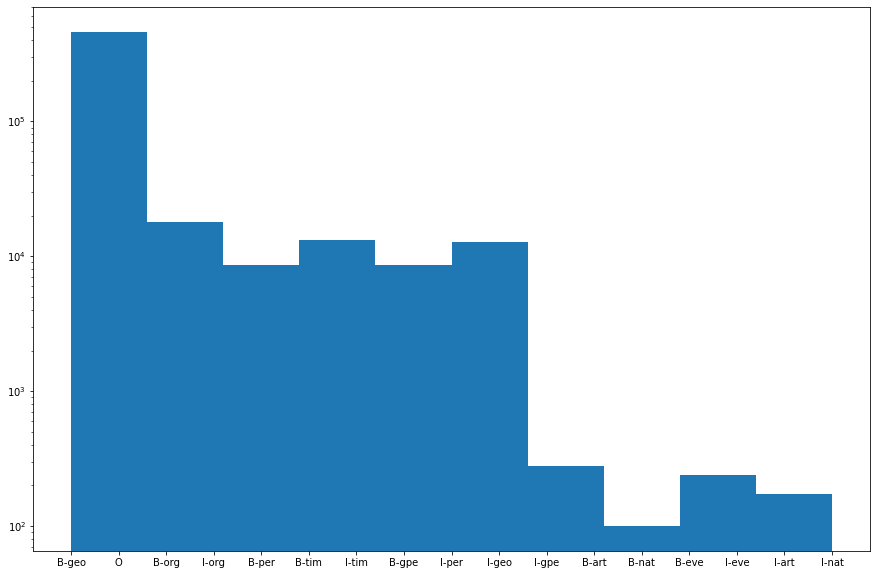

In [ ]:

plt.figure(figsize=(15,10))
plt.hist(df_train.Tag, log=True)
plt.show()

<b>Ex 2: Transform the input </b>

We know that words need to be transformed into numerical form. Transform the _tags_ and words into numbers. </br>

The tags should be one-hot encoded if you are using categorical_crossentropy, otherwise use sparse_categorical_crossentropy. </br>

Select sentences with more than 15 and less than 30 words.

For simplicity, pad the sequences with less than 30 words with 0s. **tf.keras.utils.pad_sequences** might be useful.

Create a test set to show your results.

In [ ]:
tok = tf.keras.preprocessing.text.Tokenizer()


In [ ]:
df_train.head()

,Word,Tag
Sentence #,,
22698,Russia,B-geo
22698,",",O
22698,a,O
22698,major,O
22698,non-OPEC,O


In [ ]:
tok.fit_on_texts(df_train.Word)
df_train['sequence'] = tok.texts_to_sequences(df_train.Word)
df_val['sequence'] = tok.texts_to_sequences(df_val.Word)


In [ ]:
import sklearn
le = sklearn.preprocessing.LabelEncoder()
df_train['target'] = le.fit_transform(df_train.Tag)
df_val['target'] = le.transform(df_val.Tag)


In [ ]:
df_train.head()

,Word,Tag,sequence,target
Sentence #,,,,
22698,Russia,B-geo,[206],2
22698,",",O,[],16
22698,a,O,[4],16
22698,major,O,[311],16
22698,non-OPEC,O,"[740, 2044]",16


In [ ]:
df_train = df_train.groupby(
['Sentence #'],as_index=False
)['Word', 'Tag', 'sequence', 'target'].agg({'sequence':'sum', 'Word':list, 'Tag':list, 'target':list})

df_val = df_val.groupby(
['Sentence #'],as_index=False
)['Word', 'Tag', 'sequence', 'target'].agg({'sequence':'sum', 'Word':list, 'Tag':list, 'target':list})

df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,sequence,Word,Tag,target
0,"[259, 3, 904, 14, 1478, 245, 472, 5, 480, 1, 1...","[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16..."
1,"[1, 141, 11, 1623, 84, 414, 7, 3167, 2, 1, 58,...","[The, party, is, divided, over, Britain, 's, p...","[O, O, O, O, O, B-gpe, O, O, O, O, B-geo, O, O...","[16, 16, 16, 16, 16, 3, 16, 16, 16, 16, 2, 16,..."
2,"[1, 472, 375, 331, 555, 3, 329, 122, 464, 446,...","[The, London, march, came, ahead, of, anti-war...","[O, B-geo, O, O, O, O, O, O, O, O, O, O, O, O,...","[16, 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
3,"[1, 115, 946, 310, 143, 11, 5, 627, 293, 132, ...","[The, International, Atomic, Energy, Agency, i...","[O, B-org, I-org, I-org, I-org, O, O, O, O, O,...","[16, 5, 13, 13, 13, 16, 16, 16, 16, 16, 16, 16..."
4,"[297, 28, 22, 43, 1831, 5, 887, 1054, 5, 4369,...","[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."


In [ ]:
df_val.head()

,sequence,Word,Tag,target
0,"[1, 480, 533, 10, 1, 1979, 3, 1, 1142, 481, 3,...","[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 2..."
1,"[37, 4256, 6, 136, 1561, 90, 299, 34, 560, 24,...","[Two, Germans, and, four, Nigerian, oil, worke...","[O, B-gpe, O, O, B-gpe, O, O, O, O, O, O, O, O...","[16, 3, 16, 16, 3, 16, 16, 16, 16, 16, 16, 16,..."
2,"[29, 20, 45, 1300, 777, 186, 1, 27, 20, 2, 1, ...","[It, was, not, immediately, clear, if, the, pr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo,...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
3,"[2, 93, 7, 149, 884, 32, 2460, 2221, 2, 618, 1...","[In, Saturday, 's, elections, ,, voters, will,...","[O, B-tim, O, O, O, O, O, O, O, O, O, O, O, O,...","[16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
4,"[316, 7, 33, 17, 29, 32, 898, 81, 5, 300, 110,...","[Sudan, 's, government, says, it, will, order,...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, B-...","[3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."


In [ ]:
X_train = df_train.sequence
y_train = df_train.target

X_test = df_val.sequence
y_test = df_val.target

In [ ]:
le.classes_.shape[0]

17

In [ ]:
X_train = tf.keras.utils.pad_sequences(X_train, maxlen=30, padding='pre')
y_train = tf.keras.utils.pad_sequences(y_train, maxlen=30, padding='pre',value=le.transform(['O'])[0])

X_test = tf.keras.utils.pad_sequences(X_test, maxlen=30, padding='pre')
y_test = tf.keras.utils.pad_sequences(y_test, maxlen=30, padding='pre',value=le.transform(['O'])[0])

In [ ]:
print(X_train[0])
print(y_train[0])

[   0    0    0    0    0    0    0  259    3  904   14 1478  245  472
    5  480    1  122    2   58    6  567    1  865    3  183   81   21
   12   54]
[16 16 16 16 16 16 16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16
  3 16 16 16 16 16]


In [ ]:
VOCAB_SIZE = len(tok.__dict__['word_index'])+1

<b>Create the model </b>

Now define the model, which will be many to many.

* The first layer should be Embedding, with _mask_zero_ set to True. This will propagate the mask in the network.
* Then, a SimpleRNN layer. We set here the number of hidden units. Remember to return the sequence of hidden states.
* We will define a Dense layer, with size set as the number of classes and activation softmax. 






<b> RNN MODELS </b>

Train the model with as much data as you can, changing the learning rate and hidden units. </br>


<b>Single Layer RNN Network </b></div></br>

In [ ]:
from keras. layers import SimpleRNN, Bidirectional, RNN
def generate_single_layer_RNN(hidden_size=8):
    single_RNN = tf.keras.Sequential()
    single_RNN.add(Embedding(VOCAB_SIZE, 300, mask_zero=True, input_length=30))
    single_RNN.add(SimpleRNN(hidden_size,return_sequences=True))
    single_RNN.add(Dense(le.classes_.shape[0], activation = 'softmax'))
    return single_RNN

generate_single_layer_RNN().summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 30, 300)           6281700   
                                                                 
 simple_rnn_64 (SimpleRNN)   (None, 30, 8)             2472      
                                                                 
 dense_35 (Dense)            (None, 30, 17)            153       
                                                                 
Total params: 6,284,325
Trainable params: 6,284,325
Non-trainable params: 0
_________________________________________________________________


In [ ]:
models = {'SingleRNN_hidden_8':generate_single_layer_RNN(8), 'SingleRNN_hidden_32':generate_single_layer_RNN(32), 'SingleRNN_hidden_64':generate_single_layer_RNN(64)}
scores = {}
for name, model in models.items():
    # model=models[0]
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2)
    scores[name]=model.evaluate(X_test, y_test)[1]

Epoch 1/2
295/295 [==============================] - 30s 95ms/step - loss: 0.7654 - accuracy: 0.8425 - val_loss: 0.5086 - val_accuracy: 0.8529
Epoch 2/2
185/185 [==============================] - 1s 7ms/step - loss: 0.4755 - accuracy: 0.8523
Epoch 1/2
295/295 [==============================] - 35s 114ms/step - loss: 0.5944 - accuracy: 0.8185 - val_loss: 0.4424 - val_accuracy: 0.8542
Epoch 2/2
185/185 [==============================] - 2s 12ms/step - loss: 0.4131 - accuracy: 0.8536
Epoch 1/2
295/295 [==============================] - 52s 165ms/step - loss: 0.5371 - accuracy: 0.8405 - val_loss: 0.4270 - val_accuracy: 0.8548
Epoch 2/2
185/185 [==============================] - 2s 10ms/step - loss: 0.4049 - accuracy: 0.8543


In [ ]:
scores

{'SingleRNN_hidden_32': 0.8536089062690735,
 'SingleRNN_hidden_64': 0.8542622923851013,
 'SingleRNN_hidden_8': 0.8523269295692444}

<b>k-Layer RNN Network with k=[2,3] </b></div></br>

In [ ]:
def generate_multi_layer_RNN(layers =2, hidden_size=8):
    single_RNN = tf.keras.Sequential()
    single_RNN.add(Embedding(VOCAB_SIZE, 300, mask_zero=True, input_length=30))
    for _ in range(layers):
        single_RNN.add(SimpleRNN(hidden_size,return_sequences=True))
    single_RNN.add(Dense(le.classes_.shape[0], activation = 'softmax'))
    return single_RNN

generate_multi_layer_RNN().summary()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 30, 300)           6281700   
                                                                 
 simple_rnn_68 (SimpleRNN)   (None, 30, 8)             2472      
                                                                 
 simple_rnn_69 (SimpleRNN)   (None, 30, 8)             136       
                                                                 
 dense_39 (Dense)            (None, 30, 17)            153       
                                                                 
Total params: 6,284,461
Trainable params: 6,284,461
Non-trainable params: 0
_________________________________________________________________


In [ ]:
models = {'2_layer_RNN_hidden_64':generate_multi_layer_RNN(2, 64), '2_layer_RNN_hidden_32':generate_multi_layer_RNN(2, 32), '2_layer_RNN_hidden_8':generate_multi_layer_RNN(2,8),'3_layer_RNN_hidden_64':generate_multi_layer_RNN(3,64), '3_layer_RNN_hidden_32':generate_multi_layer_RNN(3, 32), '3_layer_RNN_hidden_8':generate_multi_layer_RNN(3,8)}
for name, model in models.items():
    # model=models[0]
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)
    scores[name]=model.evaluate(X_test, y_test)[1]

Epoch 1/2
590/590 [==============================] - 67s 108ms/step - loss: 0.4772 - accuracy: 0.8487 - val_loss: 0.3988 - val_accuracy: 0.8576
Epoch 2/2
185/185 [==============================] - 2s 11ms/step - loss: 0.4004 - accuracy: 0.8545
Epoch 1/2
590/590 [==============================] - 62s 101ms/step - loss: 0.5129 - accuracy: 0.8435 - val_loss: 0.4205 - val_accuracy: 0.8559
Epoch 2/2
185/185 [==============================] - 2s 10ms/step - loss: 0.4102 - accuracy: 0.8549
Epoch 1/2
590/590 [==============================] - 71s 117ms/step - loss: 0.6944 - accuracy: 0.8000 - val_loss: 0.4931 - val_accuracy: 0.8521
Epoch 2/2
185/185 [==============================] - 2s 9ms/step - loss: 0.4488 - accuracy: 0.8521
Epoch 1/2
590/590 [==============================] - 85s 138ms/step - loss: 0.4801 - accuracy: 0.8488 - val_loss: 0.4057 - val_accuracy: 0.8565
Epoch 2/2
185/185 [==============================] - 3s 16ms/step - loss: 0.4053 - accuracy: 0.8553
Epoch 1/2
590/590 [======

<b>Bidirectional single-layer RNN </b>

In [ ]:
# Your code here
def generate_bidirectinal_RNN(layers =1, hidden_size=8):
    bidirectional_RNN = tf.keras.Sequential()
    bidirectional_RNN.add(Embedding(VOCAB_SIZE, 300, mask_zero=True, input_length=30))
    for _ in range(layers):
        bidirectional_RNN.add(Bidirectional(SimpleRNN(hidden_size,return_sequences=True)))
    bidirectional_RNN.add(Dense(le.classes_.shape[0], activation = 'softmax'))
    return bidirectional_RNN
generate_bidirectinal_RNN().summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 30, 300)           6281700   
                                                                 
 bidirectional_20 (Bidirecti  (None, 30, 16)           4944      
 onal)                                                           
                                                                 
 dense_46 (Dense)            (None, 30, 17)            289       
                                                                 
Total params: 6,286,933
Trainable params: 6,286,933
Non-trainable params: 0
_________________________________________________________________


In [ ]:
models = {'Bidirectional_RNN_hidden_64':generate_bidirectinal_RNN(1, 64), 'Bidirectional_layer_RNN_hidden_32':generate_bidirectinal_RNN(1, 32), 'Bidirectional_layer_RNN_hidden_8':generate_bidirectinal_RNN(1,8)}
for name, model in models.items():
    # model=models[0]
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)
    scores[name]=model.evaluate(X_test, y_test)[1]

Epoch 1/2
590/590 [==============================] - 69s 112ms/step - loss: 0.3671 - accuracy: 0.8679 - val_loss: 0.2563 - val_accuracy: 0.8890
Epoch 2/2
185/185 [==============================] - 2s 13ms/step - loss: 0.2636 - accuracy: 0.8856
Epoch 1/2
590/590 [==============================] - 63s 102ms/step - loss: 0.3985 - accuracy: 0.8618 - val_loss: 0.2720 - val_accuracy: 0.8857
Epoch 2/2
185/185 [==============================] - 2s 10ms/step - loss: 0.2735 - accuracy: 0.8835
Epoch 1/2
590/590 [==============================] - 61s 99ms/step - loss: 0.5391 - accuracy: 0.8495 - val_loss: 0.3760 - val_accuracy: 0.8665
Epoch 2/2
185/185 [==============================] - 2s 10ms/step - loss: 0.3269 - accuracy: 0.8721


<b>Bidirectional k-layer RNN, where k=[2,3] </b>


In [ ]:
# Your code here
models = {'2_layer_Bidirectional_RNN_hidden_64':generate_bidirectinal_RNN(2, 64), '2_layer_Bidirectional_RNN_hidden_32':generate_bidirectinal_RNN(2, 32), '2_layer_Bidirectional_RNN_hidden_8':generate_bidirectinal_RNN(2,8),'3_layer_Bidirectional_RNN_hidden_64':generate_bidirectinal_RNN(3,64), '3_layer_Bidirectional_RNN_hidden_32':generate_bidirectinal_RNN(3, 32), '3_layer_Bidirectional_RNN_hidden_8':generate_bidirectinal_RNN(3,8)}
for name, model in models.items():
    # model=models[0]
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)
    scores[name]=model.evaluate(X_test, y_test)[1]


Epoch 1/2
590/590 [==============================] - 84s 133ms/step - loss: 0.3331 - accuracy: 0.8733 - val_loss: 0.2386 - val_accuracy: 0.8934
Epoch 2/2
185/185 [==============================] - 7s 36ms/step - loss: 0.2527 - accuracy: 0.8884
Epoch 1/2
590/590 [==============================] - 91s 140ms/step - loss: 0.3674 - accuracy: 0.8668 - val_loss: 0.2554 - val_accuracy: 0.8892
Epoch 2/2
185/185 [==============================] - 3s 15ms/step - loss: 0.2569 - accuracy: 0.8881
Epoch 1/2
590/590 [==============================] - 73s 114ms/step - loss: 0.5645 - accuracy: 0.8245 - val_loss: 0.3651 - val_accuracy: 0.8662
Epoch 2/2
185/185 [==============================] - 2s 12ms/step - loss: 0.3009 - accuracy: 0.8763
Epoch 1/2
590/590 [==============================] - 101s 160ms/step - loss: 0.3488 - accuracy: 0.8694 - val_loss: 0.2466 - val_accuracy: 0.8912
Epoch 2/2
185/185 [==============================] - 5s 25ms/step - loss: 0.2575 - accuracy: 0.8879
Epoch 1/2
590/590 [====

<b>Show your results </b><br>
Show classification metrics of all your models on the test set.



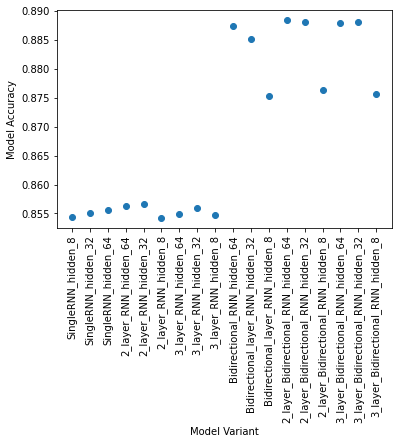

In [ ]:
# Your code here
import matplotlib.pyplot as plt
plt.scatter(scores.keys(), scores.values())
plt.xticks(rotation=90)
plt.xlabel("Model Variant")
plt.ylabel("Model Accuracy")
plt.show()

*Thus from the above plot we see that Bidirectional RNNs have a much higher accuracy than SimpleRNN layers. Additionally, we observe that higher hidden layers have a higher accuracy, but the accuracy difference between 32 and 64 hidden layers isn't much.*

## Prediction on dataset

In [144]:
id = 24
model = models['Bidirectional_RNN_hidden_64']
sequence = df_val.iloc[id, :].sequence
true_target = df_val.iloc[id, :].target
true_target = tf.keras.utils.pad_sequences([true_target], maxlen=30, padding='pre',value=le.transform(['O'])[0])
sequence = tf.keras.utils.pad_sequences([sequence], maxlen=30, padding='pre')
res = model.predict(sequence)


from prettytable import PrettyTable
PTables = PrettyTable()
PTables.field_names = ["Word", "True Label", "Predicted Label"]
for i, j, k in zip(tok.sequences_to_texts(sequence)[0].split(' '), le.inverse_transform(true_target.ravel()), le.inverse_transform(np.ravel(np.argmax(res, axis=-1)))):
  PTables.add_row([i, j,k])
print(PTables)



1/1 [==============================] - 0s 33ms/step
+-------------+------------+-----------------+
|     Word    | True Label | Predicted Label |
+-------------+------------+-----------------+
|   british   |     O      |        O        |
|   defense   |     O      |        O        |
|  officials  |     O      |        O        |
|     say     |     O      |        O        |
|      14     |     O      |        O        |
|   british   |     O      |        O        |
|   military  |     O      |        O        |
|  personnel  |     O      |        O        |
|     have    |   B-gpe    |        O        |
|     been    |     O      |        O        |
|    killed   |     O      |        O        |
|      in     |     O      |        O        |
|      a      |     O      |        O        |
|    crash    |   B-gpe    |      B-gpe      |
|      of     |     O      |        O        |
|      a      |     O      |        O        |
|     nato    |     O      |        O        |
|   airc